# Return analysis based on sentiment

In [1]:
import yfinance as yf
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

We're going to augment our data with a little more info. 
In order to be able to meaningfully compare the returns before and after an earnings call, we'll need the date of the call, the quarter that is being discussed during the call, and of course the ticker of the company. We fetch all of those infos in the first few lines of the transcripts. (it's not consistent as it depends on the transcriber)

In [2]:
ticker_regex = re.compile(r'\((.*):(.*)\)')
date_regex = re.compile(r'(\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2},\s+\d{4}\b)')
quarter_regex = re.compile(r'(Q[1-4] 202[1-3])')

In [3]:
def find_date(line):
    match = date_regex.search(line)
    if match:
        return match.group(1)
    return None
def find_ticker(line):
    match = ticker_regex.search(line)
    if match:
        return match.group(1),match.group(2)
    return None, None
def find_quarter(line):
    match = quarter_regex.search(line)
    if match:
        return match.group(1)
    return None

In [85]:

tickers = []
for transcript_loc in glob.glob("post_transcripts/*.txt"):
    with open(transcript_loc, 'r') as f:

        transcript_header = f.readline()
        date = find_date(transcript_header)
        market,ticker = find_ticker(transcript_header)
        quarter = find_quarter(transcript_header)
        if date == None or ticker == None or quarter == None:
            line = f.readline()
            if date == None:
                date = find_date(line)
            if ticker == None:
                market, ticker = find_ticker(line)
            if quarter == None:
                quarter = find_quarter(line)
        tickers.append([pd.to_datetime(date), market, ticker, quarter, transcript_loc.split('/')[1].split('.')[0]])
           



In [86]:
tickers = pd.DataFrame(tickers, columns=['date','market','ticker','quarter','transcript'])
tickers.dropna(inplace=True, axis=0)
tickers

,date,market,ticker,quarter,transcript
0,2023-03-01,NASDAQ,ORGO,Q4 2022,organogenesis-holdings-inc-orgo-q4-2022-earnin...
1,2023-04-18,OTCPK,PMNXF,Q3 2023,perseus-mining-limited-pmnxf-q3-2023-earnings-...
2,2023-04-27,OTCQB,SLGWF,Q4 2022,slang-worldwide-inc-slgwf-q4-2022-earnings-cal...
3,2023-05-04,NYSE,MRO,Q1 2023,marathon-oil-corporation-mro-q1-2023-earnings-...
5,2023-05-02,NYSE,USAC,Q1 2023,usa-compression-partners-lp-usac-q1-2023-earni...
...,...,...,...,...,...
4247,2023-03-03,OTCPK,GMPXF,Q4 2022,rf-capital-group-inc-gmpxf-q4-2022-earnings-ca...
4248,2023-05-04,NASDAQ,IPWR,Q1 2023,ideal-power-inc-ipwr-q1-2023-earnings-call-tra...
4249,2023-03-05,OTC,LCHTF,Q4 2022,livechat-software-s-lchtf-q4-2022-earnings-cal...
4250,2023-05-05,NASDAQ,SSP,Q1 2023,e-w-scripps-company-ssp-q1-2023-earnings-call-...


In [ ]:
ticker_history = yf.download(" ".join(tickers.ticker.values.tolist()), start="2023-01-01", end="2023-04-30")

[                       1%                       ]  26 of 3756 completed

KeyboardInterrupt: 

[                       1%                       ]  50 of 3756 completed

In [7]:
ticker_history.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [6]:
with open('sentiment_analysis_18_may.csv', 'r') as f:
    sentiment = pd.read_csv(f)

In [7]:
sentiment.label = sentiment.label.astype('category')
sentiment.groupby(['label']).describe()

score                                                    \
             count      mean       std       min       25%       50%   
label                                                                  
negative   20618.0  0.811128  0.162623  0.347716  0.684355  0.875272   
neutral   255470.0  0.730452  0.208228  0.346597  0.424185  0.834661   
positive   82392.0  0.821502  0.138425  0.345892  0.730868  0.873903   

                              
               75%       max  
label                         
negative  0.954800  0.978178  
neutral   0.909917  0.957547  
positive  0.939930  0.963913

## Shaping the sentiment analysis dataframe
As a first step, we're going to analyse transcripts as a whole, without studying exactly what's being said (is there positive sentiment about a rise in EPA or in debt), who said it (Operator or attendee) and when (Q&A or introduction). Instead, we're going to use the sentiment label of each sentence, count them and decide heuristically wether the call was mostly positive and negative. To study the impact on returns, we'll look at the log returns impulse response function w.r.t the calls.

In [8]:
speaker_per_transcript=sentiment.groupby('transcript')['speaker'].nunique()
speaker_per_transcript.name='speaker_count'
sentence_per_transcript=sentiment.groupby('transcript').nunique().text
sentence_per_transcript.name='sentence_count'
sentiments_per_transcript=sentiment.groupby("transcript").label.value_counts().unstack()
sentiments_per_transcript=sentiments_per_transcript.join(sentence_per_transcript).join(speaker_per_transcript)


For future ML application, we compute and store the normalized features as well.

In [9]:
sentiments_per_transcript

,negative,neutral,positive,sentence_count,speaker_count
transcript,,,,,
2seventy-bio-inc-tsvt-q1-2023-earnings-call-transcript,14,521,116,334,9
5n-plus-inc-fplsf-q1-2023-earnings-call-transcript,48,616,145,371,9
aaon-inc-aaon-q1-2023-earnings-call-transcript,62,658,261,489,9
acadia-realty-trust-akr-q4-2022-earnings-call-transcript,40,996,229,609,12
accel-entertainment-inc-acel-q1-2023-earnings-call-transcript,10,307,129,223,7
...,...,...,...,...,...
xenia-hotels-and-resorts-inc-xhr-q1-2023-earnings-call-transcript,49,703,236,475,11
xponential-fitness-inc-xpof-q1-2023-earnings-call-transcript,57,1069,305,709,16
xtant-medical-holdings-inc-xtnt-q1-2023-earnings-call-transcript,24,457,133,322,6


In [10]:
sentiments_per_transcript

,negative,neutral,positive,sentence_count,speaker_count
transcript,,,,,
2seventy-bio-inc-tsvt-q1-2023-earnings-call-transcript,14,521,116,334,9
5n-plus-inc-fplsf-q1-2023-earnings-call-transcript,48,616,145,371,9
aaon-inc-aaon-q1-2023-earnings-call-transcript,62,658,261,489,9
acadia-realty-trust-akr-q4-2022-earnings-call-transcript,40,996,229,609,12
accel-entertainment-inc-acel-q1-2023-earnings-call-transcript,10,307,129,223,7
...,...,...,...,...,...
xenia-hotels-and-resorts-inc-xhr-q1-2023-earnings-call-transcript,49,703,236,475,11
xponential-fitness-inc-xpof-q1-2023-earnings-call-transcript,57,1069,305,709,16
xtant-medical-holdings-inc-xtnt-q1-2023-earnings-call-transcript,24,457,133,322,6


In [11]:
#sentiments_per_transcript.index=sentiments_per_transcript.index.map(lambda x : x.split("/")[1].split(".")[0])
sentiments_per_transcript["ratio"]=sentiments_per_transcript.negative/sentiments_per_transcript.positive
sentiments_per_transcript["NEGATIVE_norm"]=(sentiments_per_transcript.negative-sentiments_per_transcript.negative.mean())/sentiments_per_transcript.negative.std()
sentiments_per_transcript["POSITIVE_norm"]=(sentiments_per_transcript.positive-sentiments_per_transcript.positive.mean())/sentiments_per_transcript.positive.std()
sentiments_per_transcript["ratio_norm"]=(sentiments_per_transcript.ratio-sentiments_per_transcript.ratio.mean())/sentiments_per_transcript.ratio.std()
sentiments_per_transcript["speaker_count_norm"]=sentiments_per_transcript.speaker_count/sentiments_per_transcript.speaker_count.max()
sentiments_per_transcript["sentence_count_norm"]=sentiments_per_transcript.sentence_count/sentiments_per_transcript.sentence_count.max()
sentiments_per_transcript.sort_values("ratio",ascending=False)
sentiments_per_transcript.to_csv("sentiments_normalized_base.csv")
sentiments_per_transcript.describe()

,negative,neutral,positive,sentence_count,speaker_count,ratio,NEGATIVE_norm,POSITIVE_norm,ratio_norm,speaker_count_norm,sentence_count_norm
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,4.160000e+02,4.160000e+02,4.160000e+02,416.000000,416.000000
mean,49.562500,614.110577,198.057692,428.048077,9.141827,0.278202,-3.202566e-18,-1.537232e-16,1.003471e-16,0.365673,0.388781
std,28.929094,274.862546,78.915734,160.657827,3.895822,0.190736,1.000000e+00,1.000000e+00,1.000000e+00,0.155833,0.145920
min,5.000000,98.000000,22.000000,96.000000,1.000000,0.039370,-1.540404e+00,-2.230958e+00,-1.252160e+00,0.040000,0.087193
25%,29.000000,418.000000,141.750000,318.750000,6.000000,0.160711,-7.107896e-01,-7.135167e-01,-6.159859e-01,0.240000,0.289510
50%,45.000000,578.000000,193.000000,413.000000,9.000000,0.233045,-1.577132e-01,-6.408978e-02,-2.367512e-01,0.360000,0.375114
75%,62.000000,752.000000,245.500000,526.000000,11.000000,0.344002,4.299305e-01,6.011768e-01,3.449824e-01,0.440000,0.477748
max,185.000000,1858.000000,515.000000,1101.000000,25.000000,2.136364,4.681706e+00,4.016212e+00,9.742081e+00,1.000000,1.000000


It is important for the presenters of the earning calls to be very positive in their presentation to inspire confidence to the shareholders. As such, most earning calls are pretty optimistic and mostly have positive sentences. In order to reduce this bias, we compute the ratio of the count of negative sentences over positive sentences, and normalize the ratio. Doing so, we can say that even if a transcript is mostly positive, it is "not positive enough" and we can classify it as a bad transcript w.r.t to the others.
We also take a look at the 10 best and worst tickers.

In [12]:
worst_transcripts = sentiments_per_transcript.sort_values("ratio_norm", ascending=False).head(10).index.values
best_transcripts = sentiments_per_transcript.sort_values("ratio_norm", ascending=True).head(10).index.values
bad_transcripts = sentiments_per_transcript[sentiments_per_transcript.ratio_norm > 0.2].index.values
average_transcripts = sentiments_per_transcript[(sentiments_per_transcript.ratio_norm < 0.2) & (sentiments_per_transcript.ratio_norm > -0.2)].index.values
good_transcripts = sentiments_per_transcript[sentiments_per_transcript.ratio_norm < -0.2].index.values

In [17]:
# Breakdown of the quarters that are going to be analyzed
tickers.quarter.value_counts()

Q1 2023    2018
Q4 2022    1552
Q2 2023     138
Q3 2023     125
Q4 2023      93
Q3 2022       4
Q2 2022       1
Name: quarter, dtype: int64

In [16]:
worst_ticker_history = yf.download(" ".join(tickers[tickers.transcript.isin(worst_transcripts)].ticker.values.tolist()), start="2023-05-01", end="2023-05-10")
best_ticker_history = yf.download(" ".join(tickers[tickers.transcript.isin(best_transcripts)].ticker.values.tolist()), start="2023-05-01", end="2023-05-10")

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [17]:
good_ticker_history = yf.download(" ".join(tickers[tickers.transcript.isin(good_transcripts)].ticker.values.tolist()), start="2023-04-20", end="2023-05-15")
bad_ticker_history = yf.download(" ".join(tickers[tickers.transcript.isin(bad_transcripts)].ticker.values.tolist()), start="2023-04-20", end="2023-05-15")
average_ticker_history = yf.download(" ".join(tickers[tickers.transcript.isin(average_transcripts)].ticker.values.tolist()), start="2023-04-20", end="2023-05-15")

[*********************100%***********************]  210 of 210 completed

1 Failed download:
- CTTPY: No data found for this date range, symbol may be delisted
[*********************100%***********************]  119 of 119 completed

1 Failed download:
- ODJAF: No data found, symbol may be delisted
[*********************100%***********************]  82 of 82 completed

1 Failed download:
- COCAL: No data found, symbol may be delisted


In [18]:
# For each ticker, we get the following info for each day
average_ticker_history.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [91]:
def compute_log_returns(df):
    for ticker in df["Adj Close"].columns.unique():
        if len(tickers[(tickers.ticker == ticker)]):
            df['log_returns', ticker] = np.log(df['Adj Close', ticker]) - np.log(df['Adj Close', ticker].shift(1))
            df['transcript_date',ticker]= tickers[(tickers.ticker == ticker)].date.values[0]
    return df

In [14]:
# Computes the expected log returns of all stocks after and before their earning calls transcripts are released 
def compute_IRF(df, range_of_days_before, range_of_days_after):
    mean_acc=[[] for i in range(range_of_days_before + range_of_days_after)]
    std_acc=[[] for i in range(range_of_days_before + range_of_days_after)]
    acc=[[] for i in range(range_of_days_before + range_of_days_after)]
    for ticker in df.columns.get_level_values(1).unique():
        for transcript_date in tickers[(tickers.ticker == ticker)].date.values:
            try:
                df['log_returns', ticker].loc[transcript_date]
            except KeyError:
                break
        dates_before = [pd.to_datetime(df["transcript_date",ticker].values[0]) - pd.Timedelta(days=i) for i in range(range_of_days_before)]
        dates_after = [pd.to_datetime(df["transcript_date", ticker].values[0]) + pd.Timedelta(days=i) for i in range(range_of_days_after)]
        dates = dates_before + dates_after
        for (i, date) in enumerate(dates):
            try:

                acc[i].append(df['log_returns', ticker].loc[date])
            except KeyError:
                pass
    for day in range(len(mean_acc)):
        mean_acc[day]=np.mean([x for x in acc[day] if x==x])
        std_acc[day]=np.std([x for x in acc[day] if x==x])
        #TODO the std is not the std we're looking for, we need bootstrapping to compute a CI for the IRF
    return mean_acc,std_acc

Text(0, 0.5, 'Average Log Returns')

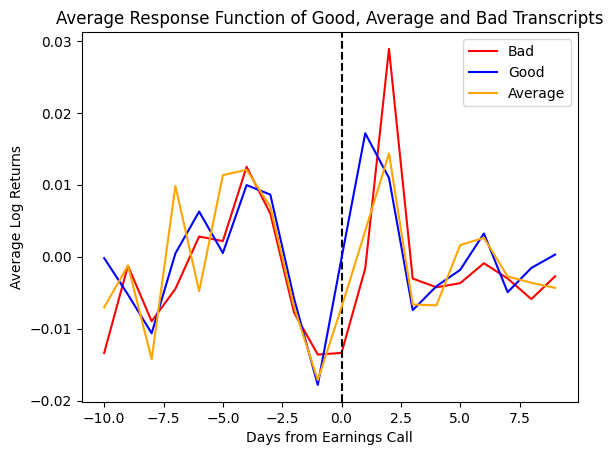

In [32]:
days_before = 10
days_after = 10
compute_log_returns(bad_ticker_history)
bad_response_function_mean, bad_response_function_std = compute_IRF(bad_ticker_history, days_before, days_after)
x = np.arange(-days_before, days_after)
plt.plot(x, bad_response_function_mean, color='r', label='Bad')
#plt.fill_between(x, np.array(bad_response_function_mean) - np.array(bad_response_function_std), np.array(bad_response_function_mean) + np.array(bad_response_function_std), alpha=0.2, color='r')
plt.axvline(x=0, color='k', linestyle='--')
compute_log_returns(good_ticker_history)
good_response_function_mean, good_response_function_std = compute_IRF(good_ticker_history, days_before, days_after)
plt.plot(x, good_response_function_mean, color='b', label='Good')
#plt.fill_between(x, np.array(good_response_function_mean) - np.array(good_response_function_std), np.array(good_response_function_mean) + np.array(good_response_function_std), alpha=0.2)

compute_log_returns(average_ticker_history)
avg_response_function, avg_response_function_std = compute_IRF(average_ticker_history, days_before, days_after)
plt.plot(x, avg_response_function, color='orange', label='Average')
plt.legend()
plt.title("Average Response Function of Good, Average and Bad Transcripts")
plt.xlabel("Days from Earnings Call")
plt.ylabel("Average Log Returns")

This is really not conclusive for the moment. As a sanity check, we can verify wether or not Earning calls are anticipated by shareholders by looking at the volume of transactions. To be able to compare the volumes of all stocks (since some are way bigger than others), we'll normalize them first. 

In [70]:
def normalize_volume(df):
    for ticker in df["Volume"].columns.unique():
        df['norm_volume', ticker] = (df['Volume', ticker]/df['Volume', ticker].mean()) *100
    return df

In [16]:
# Computes the mean volume around the earning call date
def compute_mean_volume(df, range_of_days_before, range_of_days_after):
    mean_acc=[[] for i in range(range_of_days_before + range_of_days_after)]
    acc=[[] for i in range(range_of_days_before + range_of_days_after)]
    for ticker in df.columns.get_level_values(1).unique():
        dates_before = [pd.to_datetime(df["transcript_date",ticker].values[0]) - pd.Timedelta(days=i) for i in range(range_of_days_before)][::-1][:-1]
        dates_after = [pd.to_datetime(df["transcript_date", ticker].values[0]) + pd.Timedelta(days=i) for i in range(range_of_days_after)]
        dates = dates_before + dates_after
        for (i, date) in enumerate(dates):
            try:
                acc[i].append(df['norm_volume', ticker].loc[date])
            except KeyError:
                pass
    for day in range(len(mean_acc)):
        mean_acc[day]=np.mean([x for x in acc[day] if x==x])
    return mean_acc

In [22]:
# As we can see, some stucks in fact have zero volume. It doesn't make much sense to include them.
normalize_volume(best_ticker_history)
# TODO Drops all stocks that have zero volume
#worst_ticker_history[worst_ticker_history['norm_volume'] == pd.nan]
#worst_ticker_history = worst_ticker_history.dropna(axis=1, how='any')



NameError: name 'best_ticker_history' is not defined

/home/lucastrg/pyenvs/finance-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucastrg/pyenvs/finance-env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Normalized volume around earning call date')

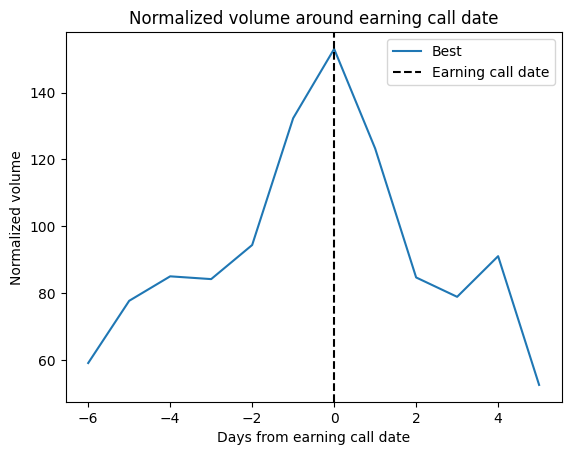

In [28]:
# Compute the average volume of all stocks that have non-zero volume
compute_log_returns(best_ticker_history)
plt.plot(x,compute_mean_volume(best_ticker_history, days_before, days_after), label='Best')
plt.axvline(x=0, color='k', linestyle='--', label='Earning call date')
plt.legend()
plt.xlabel('Days from earning call date')
plt.ylabel('Normalized volume')
plt.title('Normalized volume around earning call date')


/tmp/ipykernel_5213/343363724.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['norm_volume', ticker] = (df['Volume', ticker]/df['Volume', ticker].mean()) *100
/home/lucastrg/pyenvs/finance-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucastrg/pyenvs/finance-env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5213/343363724.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

Text(0.5, 1.0, 'Normalized volume around earning call date')

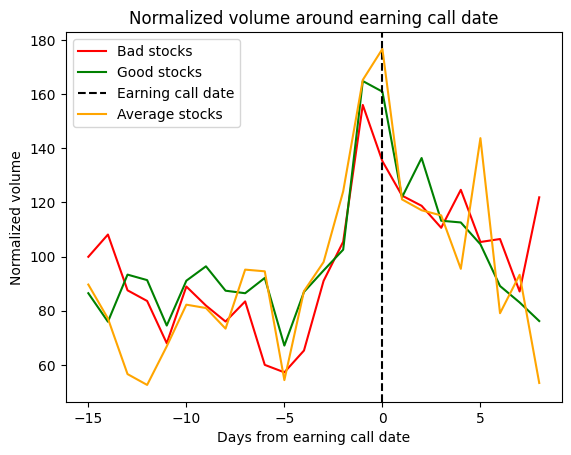

In [29]:
compute_log_returns(bad_ticker_history)
normalize_volume(bad_ticker_history)
days_before = 15
days_after = 10
x = np.arange(-days_before, days_after)
plt.plot(x,compute_mean_volume(bad_ticker_history, days_before, days_after), color='r', label='Bad stocks')

compute_log_returns(good_ticker_history)
normalize_volume(good_ticker_history)
plt.plot(x,compute_mean_volume(good_ticker_history, days_before, days_after) , color='g', label='Good stocks')
plt.axvline(x=0, color='k', linestyle='--', label='Earning call date')

compute_log_returns(average_ticker_history)
normalize_volume(average_ticker_history)
plt.plot(x,compute_mean_volume(average_ticker_history, days_before, days_after) , color='orange', label='Average stocks')


plt.legend()
plt.xlabel('Days from earning call date')
plt.ylabel('Normalized volume')
plt.title('Normalized volume around earning call date')


In [30]:
good_ticker_history["norm_volume"]

,AAON,ACEL,ACIW,AEHL,AFRAF,AINC,AKR,AKRTF,ALKT,AMGDF,...,WLDN,WLKP,WOW,XFOR,XHR,XPOF,XTNT,ZETA,ZEUS,ZLDSF
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-19 00:00:00,78.670426,94.974256,37.667349,41.148943,144.827586,16.605166,114.961728,NaN,50.388555,368.079800,...,95.501086,69.442132,44.261074,106.192359,86.324650,103.785127,6.010017,49.004047,76.293788,0.0
2023-04-20 00:00:00,122.335702,112.197567,44.222623,110.956915,12.413793,66.420664,77.943262,NaN,43.672730,0.000000,...,59.199504,87.676936,50.520215,44.888342,63.378455,53.316765,112.687813,64.518842,103.153773,0.0
2023-04-21 00:00:00,64.388811,72.337905,56.348181,140.874617,0.000000,308.856089,72.175432,NaN,52.454963,125.685786,...,146.881787,42.464613,42.547261,93.382012,90.378796,93.251768,108.180301,65.912077,82.770664,0.0
2023-04-24 00:00:00,85.993551,97.106666,80.752139,230.434081,206.896552,6.642066,102.058148,NaN,51.779407,116.708229,...,128.172510,73.438801,61.448875,71.524716,85.587533,63.238387,45.075125,43.663311,82.675415,0.0
2023-04-25 00:00:00,65.968905,87.551829,84.946835,95.852832,211.034483,0.000000,97.714648,NaN,156.570117,0.000000,...,37.697797,100.166528,44.062371,73.603160,79.240132,61.709042,60.100167,61.534566,82.770664,1800.0
2023-04-26 00:00:00,133.943312,84.025152,69.068128,11.812167,0.000000,23.247232,104.370921,NaN,186.691982,0.000000,...,92.150171,87.427144,63.460742,180.044394,69.207144,112.062703,55.592654,52.211929,115.536036,0.0
2023-04-27 00:00:00,199.942603,77.340867,71.072072,19.267387,0.000000,39.852399,70.595978,NaN,57.620982,8.977556,...,37.697797,40.716070,61.597903,89.497541,80.209305,55.266679,431.218698,110.100001,66.768970,0.0
2023-04-28 00:00:00,97.965798,86.854695,121.714108,75.520413,198.620690,61.439114,105.343978,NaN,70.774461,8.977556,...,65.622091,53.205662,96.370912,65.121224,97.668070,94.647295,82.637730,133.243190,127.156313,0.0
2023-05-01 00:00:00,99.940915,74.388299,98.091347,350.104889,0.000000,49.815498,152.078910,NaN,154.940834,0.000000,...,63.388148,111.407161,66.068718,104.974888,66.040268,89.581342,42.070117,93.166171,111.726109,0.0


This is solid evidence that the market is very much aware of the earning calls. As shareholders are anticipating the earning calls, they are trading less and less shares. When the call finally happens, volume spikes up again. We can be confident that the earning calls are a very important event to the market.

In [23]:
sentiment

,transcript,speaker,text,label,score
0,ashford-inc-ainc-q1-2023-earnings-call-transcript,OPERATOR,Ashford Inc,neutral,0.925325
1,ashford-inc-ainc-q1-2023-earnings-call-transcript,OPERATOR,(NYSE:AINC) Q1 2023 Earnings Conference Call ...,neutral,0.591237
2,ashford-inc-ainc-q1-2023-earnings-call-transcript,OPERATOR,Welcome to the Ashford Incorported First Quar...,neutral,0.873380
3,ashford-inc-ainc-q1-2023-earnings-call-transcript,OPERATOR,At this time all participants are in a listen...,neutral,0.953002
4,ashford-inc-ainc-q1-2023-earnings-call-transcript,OPERATOR,A question-and-answer session will follow the...,neutral,0.952218
...,...,...,...,...,...
358475,ring-energy-rei-q1-2023-earnings-call-transcript,Jeff Grampp,Got it,neutral,0.913204
358476,ring-energy-rei-q1-2023-earnings-call-transcript,Jeff Grampp,Okay,neutral,0.896818
358477,ring-energy-rei-q1-2023-earnings-call-transcript,Jeff Grampp,That’s helpful,neutral,0.815940
358478,ring-energy-rei-q1-2023-earnings-call-transcript,Jeff Grampp,Thanks guys,neutral,0.725234


In [80]:
all_ticker_history = yf.download(" ".join(tickers.ticker.values.tolist()), start="2023-03-20", end="2023-05-20")


[*********************100%***********************]  3756 of 3756 completed

145 Failed downloads:
- OPERATOR: No data found, symbol may be delisted
- ROSENBLATT: No data found, symbol may be delisted
- PRESIDENT: No data found, symbol may be delisted
- INVESTOR: No data found, symbol may be delisted
- LUSTGARTEN: No data found, symbol may be delisted
- LIKE: No data found, symbol may be delisted
- OF: No data found for this date range, symbol may be delisted
- EXECUTIVE: No data found, symbol may be delisted
- COF.PK: No data found, symbol may be delisted
- MELLOR: No data found, symbol may be delisted
- ABERNETHY: No data found, symbol may be delisted
- C.PK: No data found, symbol may be delisted
- THAT: No data found, symbol may be delisted
- THE: No data found for this date range, symbol may be delisted
- EUCMF: No data found, symbol may be delisted
- YUSHENG: No data found, symbol may be delisted
- BAC.PK: No data found, symbol may be delisted
- 15: No data found, symbol may be del

In [83]:
all_ticker_history.dropna(axis=1, how='any', inplace=True)

In [ ]:
sen

In [109]:
tickers[tickers.transcript=="aaon-inc-aaon-q1-2023-earnings-call-transcript"].date

2385   2023-05-04
Name: date, dtype: datetime64[ns]

In [132]:
# Saves the normalized sentiment analysis data alongside the log returns before the earning call date
ranges_of_days_before = 10
ranges_of_days_after = 10
log_returns_columns = [f'log_returns' for i in range(-ranges_of_days_before, ranges_of_days_after)]
acc = []
dataset = pd.DataFrame(columns=['ticker', 'ratio_norm', 'speaker_count_norm', 'sentence_count_norm', 'positive_norm', 'negative_norm' ]+log_returns_columns)
compute_log_returns(all_ticker_history)
normalize_volume(all_ticker_history)

for ticker in all_ticker_history.columns.get_level_values(1).unique():
    entry={}
    print(ticker)
    transcript = tickers[tickers.ticker == ticker].transcript
    try:
        entry["ticker"] = ticker
        entry["ratio_norm"] = sentiments_per_transcript.loc[transcript].ratio_norm.values[0]
    except Exception as e:
        print(e)
        continue
    entry["speaker_count_norm"] = sentiments_per_transcript.loc[transcript].speaker_count_norm.values[0]
    entry["sentence_count_norm"] = sentiments_per_transcript.loc[transcript].sentence_count_norm.values[0]
    entry["positive_norm"] = sentiments_per_transcript.loc[transcript].POSITIVE_norm.values[0]
    entry["negative_norm"] = sentiments_per_transcript.loc[transcript].NEGATIVE_norm.values[0]
    for  day in range(-ranges_of_days_before, ranges_of_days_after):
        try:
            entry[f'log_returns_{day}'] = all_ticker_history['log_returns', ticker].loc[pd.to_datetime(tickers[tickers.ticker==ticker].date.values[0]) + pd.Timedelta(days=day)]       
        except Exception as e:
            print(f"No trading data for ticker {ticker}/{transcript} : {e}")
            entry[f'log_returns_{day}'] = np.nan
    acc.append(entry)
dataset = pd.DataFrame.from_records(acc)
"""all_ticker_history['transcript_date',ticker]= tickers[(tickers.ticker == ticker)].date.values[0]
        all_ticker_history['ratio_norm', ticker]=sentiments_per_transcript.loc[ticker].ratio_norm
        all_ticker_history['speaker_count_norm', ticker]=sentiments_per_transcript.loc[ticker].speaker_count_norm
        all_ticker_history['sentence_count_norm', ticker]=sentiments_per_transcript.loc[ticker].sentence_count_norm
        all_ticker_history['positive_norm', ticker]=sentiments_per_transcript.loc[ticker].POSITIVE_norm
        all_ticker_history['negative_norm', ticker]=sentiments_per_transcript.loc[ticker].NEGATIVE_norm """
   


/home/lucastrg/pyenvs/finance-env/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


AA
"None of [Index(['alcoa-corporation-aa-q1-2023-earnings-call-transcript'], dtype='object', name='transcript')] are in the [index]"
AACG
"None of [Index(['ata-creativity-global-aacg-q4-2022-earnings-call-transcript'], dtype='object', name='transcript')] are in the [index]"
AADI
"None of [Index(['aadi-bioscience-inc-aadi-q4-2022-earnings-call-transcript'], dtype='object', name='transcript')] are in the [index]"
AAGIY
"None of [Index(['aia-group-limited-aagiy-q4-2022-earnings-call-transcript'], dtype='object', name='transcript')] are in the [index]"
AAL
"None of [Index(['american-airlines-group-inc-aal-q1-2023-earnings-call-transcript'], dtype='object', name='transcript')] are in the [index]"
AAMC
"None of [Index(['altisource-asset-management-corporation-aamc-q4-2022-earnings-call-transcript'], dtype='object', name='transcript')] are in the [index]"
AAN
"None of [Index(['aarons-company-inc-aan-q1-2023-earnings-call-transcript', 'aarons-company-inc-aan-q4-2022-earnings-call-transcript']

"all_ticker_history['transcript_date',ticker]= tickers[(tickers.ticker == ticker)].date.values[0]\n        all_ticker_history['ratio_norm', ticker]=sentiments_per_transcript.loc[ticker].ratio_norm\n        all_ticker_history['speaker_count_norm', ticker]=sentiments_per_transcript.loc[ticker].speaker_count_norm\n        all_ticker_history['sentence_count_norm', ticker]=sentiments_per_transcript.loc[ticker].sentence_count_norm\n        all_ticker_history['positive_norm', ticker]=sentiments_per_transcript.loc[ticker].POSITIVE_norm\n        all_ticker_history['negative_norm', ticker]=sentiments_per_transcript.loc[ticker].NEGATIVE_norm "

In [133]:
dataset

,ticker,ratio_norm,speaker_count_norm,sentence_count_norm,positive_norm,negative_norm,log_returns_-10,log_returns_-9,log_returns_-8,log_returns_-7,...,log_returns_0,log_returns_1,log_returns_2,log_returns_3,log_returns_4,log_returns_5,log_returns_6,log_returns_7,log_returns_8,log_returns_9
0,AAON,-0.213142,0.36,0.444142,0.797589,0.429931,-0.008481,-0.010089,-0.038741,0.054896,...,-0.013104,0.069989,NaN,NaN,-0.063055,-0.002789,0.004747,-0.013995,-0.011550,NaN
1,ACT,0.402443,0.44,0.470481,0.810261,1.501516,-0.009510,-0.004581,-0.014292,0.011785,...,-0.063721,0.067941,NaN,NaN,0.004202,0.022799,-0.019868,-0.008396,0.003367,NaN
2,ADNT,0.410808,0.40,0.534060,0.582169,1.294112,NaN,0.002589,-0.049553,0.000815,...,-0.079505,-0.014972,0.027711,NaN,NaN,0.031155,-0.014041,0.005078,0.003371,-0.016113
3,AEHL,-0.709592,0.28,0.190736,-1.711417,-1.402135,NaN,NaN,-0.018869,0.009479,...,0.035718,-0.008811,0.000000,0.000000,NaN,NaN,0.008811,-0.017700,-0.027151,0.018182
4,AES,-0.193963,0.04,0.516803,0.011941,-0.054011,-0.012076,-0.034523,0.021875,0.003811,...,0.008416,NaN,NaN,-0.043270,0.025468,0.016478,-0.027313,0.003625,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,WRLD,0.966250,0.40,0.191644,-1.495997,-0.434251,0.057083,-0.013670,0.045756,0.029883,...,0.069334,0.062461,NaN,NaN,0.029204,-0.058816,0.008163,-0.028051,0.008041,NaN
279,XPRO,-0.155099,0.36,0.603996,2.077435,1.397814,0.040885,-0.032056,-0.009873,0.005208,...,-0.053316,0.001710,NaN,NaN,0.010762,0.023937,-0.001652,-0.046809,0.008051,NaN
280,ZETA,-0.792541,0.44,0.501362,1.380489,-0.365117,-0.020439,-0.053521,0.011346,0.013245,...,-0.005432,-0.095964,NaN,NaN,-0.008429,-0.002421,0.018018,-0.013182,-0.019489,NaN
281,ZEUS,-0.422193,0.04,0.285195,-0.330196,-0.537953,-0.057125,-0.044725,0.022613,-0.045749,...,0.047470,NaN,NaN,-0.071146,0.016152,-0.015919,-0.014524,-0.011152,NaN,NaN


In [115]:
dataset.to_csv("timeseries_data/dataset.csv")

,ticker,ratio_norm,speaker_count_norm,sentence_count_norm,positive_norm,negative_norm,log_returns,log_returns,log_returns,log_returns,...,log_returns_4,log_returns_5,log_returns_6,log_returns_7,log_returns_8,log_returns_-5,log_returns_2,log_returns_9,log_returns_-4,log_returns_3
transcript,,,,,,,,,,,,,,,,,,,,,
aaon-inc-aaon-q1-2023-earnings-call-transcript,ZZHGF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,-0.002255,-0.01317,0.025278,0.02586,-0.071146


In [51]:
all_ticker_history.dropna(axis=1, how='any').dropna(axis=0, how='any').columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'transcript_date', 'norm_volume'],
      dtype='object')

In [54]:
all_ticker_history

Adj Close                                         \
                            ABG        ADC      ADMP   ADXN         AL   
Date                                                                     
2023-03-20 00:00:00  200.240005  68.839996  7.083999  1.190  37.189999   
2023-03-21 00:00:00  204.250000  67.269997  7.328999  1.160  38.020000   
2023-03-22 00:00:00  198.759995  64.949997  8.399999  1.200  37.150002   
2023-03-23 00:00:00  197.960007  64.940002  8.399999  1.060  36.610001   
2023-03-24 00:00:00  198.360001  67.089996  8.329999  1.160  36.619999   
2023-03-27 00:00:00  198.539993  67.000000  8.385999  1.080  37.330002   
2023-03-28 00:00:00  199.389999  67.220001  8.049999  1.130  37.389999   
2023-03-29 00:00:00  199.649994  67.550003  8.616999  1.130  37.730000   
2023-03-30 00:00:00  206.460007  67.510002  8.399999  0.970  38.619999   
2023-03-31 00:00:00  210.000000  68.610001  8.112999  0.946  39.369999   
2023-04-03 00:00:00  209.979996  67.860001  7.699999  0.994  38.880001   
2023-04-04 00:00:00  203.460007  67.660004  7.762999  0.923  38.500000   
2023-04-05 00:00:00  194.669998  67.040001  6.999999  0.756  38.299999   
2023-04-06 00:00:00  193.539993  66.809998  7.279999  0.730  38.889999   
2023-04-10 00:00:00  196.460007  67.519997  7.006999  0.763  39.279999   
2023-04-11 00:00:00  205.360001  67.099998  6.593999  0.788  39.000000   
2023-04-12 00:00:00  203.770004  66.070000  6.523999  0.800  39.689999   
2023-04-13 00:00:00  205.270004  66.360001  6.712999  0.799  39.790001   
2023-04-14 00:00:00  208.270004  66.099998  6.558999  0.775  39.529999   
2023-04-17 00:00:00  204.630005  67.470001  6.586999  0.745  39.820000   
2023-04-18 00:00:00  208.080002  67.309998  6.908999  0.663  40.000000   
2023-04-19 00:00:00  206.300003  67.209999  6.649999  0.739  39.770000   
2023-04-20 00:00:00  204.880005  67.209999  6.719999  0.690  39.049999   
2023-04-21 00:00:00  203.929993  67.089996  6.579999  0.750  39.360001   
2023-04-24 00:00:00  206.869995  66.680000  6.299999  0.723  38.980000   
2023-04-25 00:00:00  187.639999  66.820000  6.068999  0.750  38.340000   
2023-04-26 00:00:00  186.029999  66.279999  5.774999  0.750  38.540001   
2023-04-27 00:00:00  193.190002  67.760002  5.648999  0.700  39.689999   
2023-04-28 00:00:00  193.460007  67.989998  5.809999  0.710  40.220001   
2023-05-01 00:00:00  198.330002  67.410004  5.627999  0.760  40.189999   
2023-05-02 00:00:00  196.070007  66.750000  5.676999  0.758  38.840000   
2023-05-03 00:00:00  191.820007  66.510002  5.319999  0.723  37.959999   
2023-05-04 00:00:00  189.410004  67.500000  5.459999  0.739  36.459999   
2023-05-05 00:00:00  196.929993  68.160004  4.899999  0.727  37.840000   
2023-05-08 00:00:00  201.880005  67.720001  4.976999  0.730  37.560001   
2023-05-09 00:00:00  202.070007  67.040001  4.899999  0.747  38.130001   
2023-05-10 00:00:00  204.179993  67.400002  5.599999  0.943  38.000000   
2023-05-11 00:00:00  203.610001  66.410004  5.599999  0.889  38.169998   
2023-05-12 00:00:00  199.470001  66.839996  5.529999  0.880  38.099998   
2023-05-15 00:00:00  202.059998  66.860001  4.899999  0.843  38.540001   
2023-05-16 00:00:00  197.529999  65.339996  4.864999  0.755  37.880001   
2023-05-17 00:00:00  205.669998  65.720001  4.619999  0.790  38.919998   
2023-05-18 00:00:00  208.759995  66.059998  4.759999  0.751  39.080002   
2023-05-19 00:00:00  204.229996  65.930000  3.499999  0.727  38.820000   

                                                                         ...  \
                           ALV       ANDE   BWAY        CBOE      CDNIF  ...   
Date                                                                     ...   
2023-03-20 00:00:00  86.669998  39.169998  1.920  125.650002  20.540001  ...   
2023-03-21 00:00:00  89.419998  40.290001  1.870  128.380005  20.540001  ...   
2023-03-22 00:00:00  87.919998  39.590000  1.860  127.059998  20.540001  ...   
2023-03-23 00:00:00  87.989998  39.209999  1.850  127.180000  2